In [1]:
%matplotlib inline
import numpy as np
import cv2
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from lesson_functions import *

from sklearn.metrics import accuracy_score, f1_score, make_scorer
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC



In [2]:
vehicles=glob.glob('data/vehicles/*/*')
non_vehicles=glob.glob('data/non-vehicles//*/*')

all_images=np.concatenate([vehicles,non_vehicles])
y=np.array([1 for i in vehicles]+[0 for i in non_vehicles],dtype=np.uint8)
folder=[a.split('/')[2] for a in all_images]
#images=np.array([cv2.imread(a) for a in all_images])

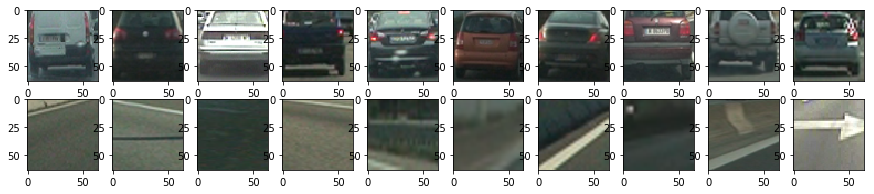

In [3]:
fig, ax = plt.subplots(2,10)
fig.set_figwidth(15)
fig.set_figheight(3)

for i in range(10):
    ax[0][i].imshow(mpl.image.imread(all_images[np.where(y==1)[0][i]]))
    ax[1][i].imshow(mpl.image.imread(all_images[np.where(y==0)[0][i]]))
    

In [4]:
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [5]:
from tqdm import tqdm_notebook
import os


color_space =  'RGB'#, 'HSV', 'LUV', 'HLS', 'YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
color_spaces=['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

if os.path.exists('all_features.npy'):
    all_features=np.load('all_features.npy')
else:
    images=np.array([cv2.imread(a) for a in all_images])
    all_features=np.array([extract_features(images, color_space=sp, 
                       spatial_size=spatial_size, hist_bins=hist_bins, 
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, 
                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                       hist_feat=hist_feat, hog_feat=hog_feat, preprocessing=False,from_file=False) for sp in \
              tqdm_notebook(color_spaces)])
    np.save('all_features.npy',all_features)
    del(images)

# todo - normal train/test split

In [ ]:
color_spaces=['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

preds=np.zeros((len(color_spaces),len(y)),dtype=np.uint8)
preds2=np.zeros((len(color_spaces),len(y)),dtype=np.uint8)


pl=Pipeline([ \
             ('scalar',StandardScaler()), \
            ('svc',LinearSVC())])

res=[]
preds=np.zeros((len(color_spaces),len(y)),dtype=np.uint8)

for i in tqdm_notebook(range(len(color_spaces)),desc='colorspace'):
        z=all_features[i].copy()
        z[np.isnan(z)]=0
        cv=skf.split(z,y)
        for a,b in cv:
            pl=Pipeline([ \
             ('scalar',StandardScaler()), \
             ('svm',LinearSVC())])
            pl.fit(z[a], y[a])
            pred=pl.predict(z[b])
            res.append([accuracy_score(y[b],pred), f1_score(y[b],pred)])
            preds[i][b]=pred
        
        print (color_spaces[i], np.mean(res,axis=0))


RGB [ 0.98519152  0.98498956]
HSV [ 0.98851359  0.98836872]
LUV [ 0.98988369  0.98975707]
HLS [ 0.99001975  0.98989902]


In [ ]:
#looking at ensemble - the best score
print ('Ensembling score:', f1_score(y,np.median(preds,axis=0).astype(np.uint8)))

# training models

In [6]:
import pickle
if os.path.exists('clf.pk1'):
    with open('clf.pk1','rb') as f:
        pls=pickle.load(f)
else:
    
    pls=[Pipeline([ \
                 ('scalar',StandardScaler()), \
                 ('svm',LinearSVC())]) for i in range(len(color_spaces))]

    for i in tqdm_notebook(range(len(color_spaces))):
        z=all_features[i]
        z[np.isnan(z)]=0
        pls[i].fit(z,y)
        
    with open('clf.pk','wb') as f:
        pickle.dump(pls,f,-1)
        

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc,  color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size,
              hist_bins, heatmap=None,heat_thresh=3):
    draw_img = np.copy(img)
    #img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop, :, :]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2' + color_space)
    if color_space != 'RGB':
            if color_space == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
    
    
    imshape = ctrans_tosearch.shape
    ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - 1
    
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog=np.array([get_hog_features(ctrans_tosearch[:,:,i], orient, pix_per_cell, cell_per_block, feature_vec=False)\
                for i in range(3)])
    
    features=[]
    boxes=[]
    
    window_size=int(window*scale)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos,ypos = xb * cells_per_step, yb * cells_per_step
            xleft, ytop = xpos * pix_per_cell,  ypos * pix_per_cell
            x, y = int(xleft*scale), int(ytop*scale)
            
            box= ((x,y+ystart),(x+window_size,y+window_size+ystart))
            #print (box)
            if heatmap!=None and heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]].max()<heat_thresh:
                continue
            
            # Extract HOG for this patch
            hog_features = np.hstack([hog[i,ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()\
                                     for i in range(3)])
       
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            features.append(np.hstack((spatial_features, hist_features, hog_features)))
            boxes.append(box)
            
   
    return np.array(features),boxes
    


In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bboxes=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return bboxes

def get_heat (image, box_list, threshhold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)


    # Add heat to each box in box list
    heat = add_heat(heat,box_list)


    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshhold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    return heatmap

def get_labels(image, heatmap,label_threshhold=3, verbose=False):
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    labeled_boxes=get_labeled_bboxes(labels)
    #print (labeled_boxes)
    

    good_labels=[a for a in labeled_boxes if heatmap[a[0][1]:a[1][1],a[0][0]:a[1][0]].max()>label_threshhold]
    
    draw_img = draw_boxes(np.copy(image), good_labels)
    return  draw_img

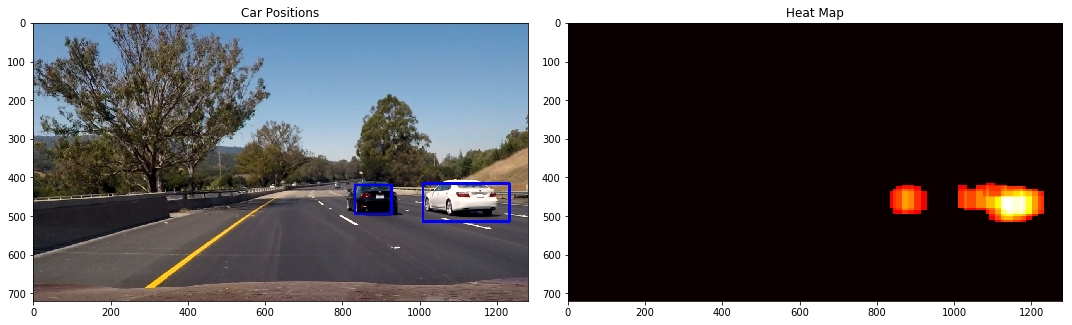

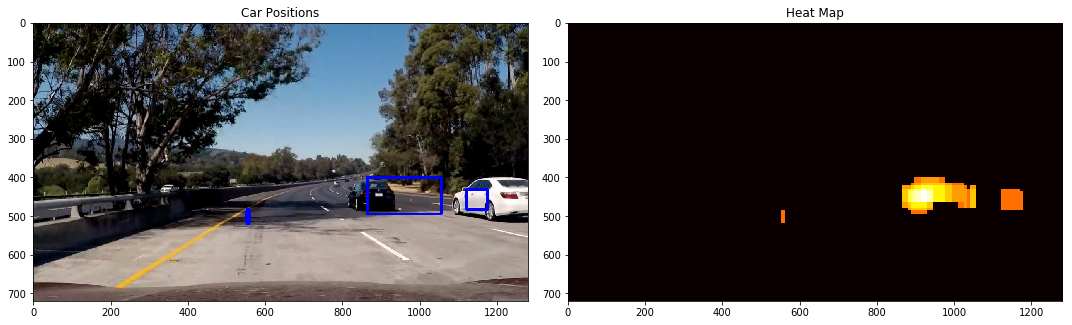

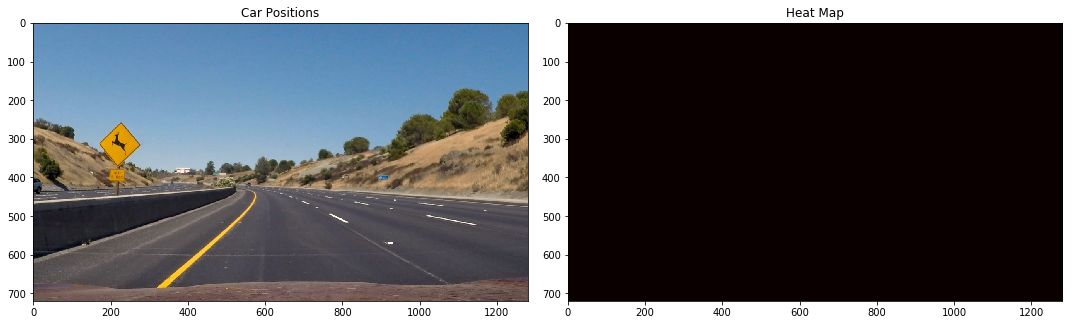

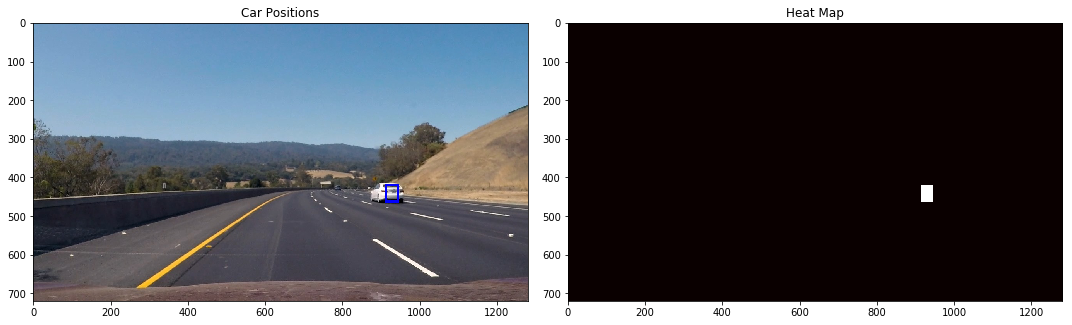

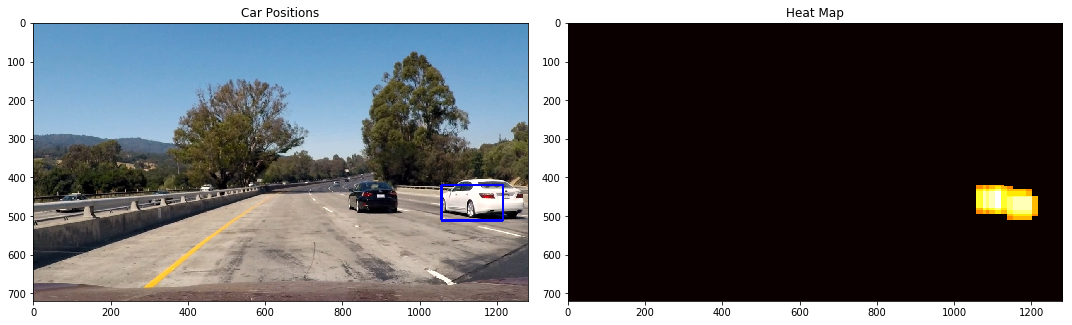

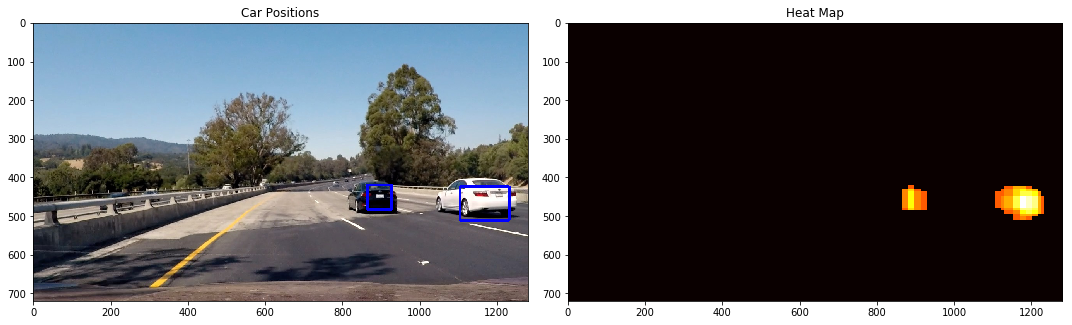

CPU times: user 32.9 s, sys: 20.8 s, total: 53.7 s
Wall time: 22.1 s


In [11]:
%%time
import pickle 

## Load model params
svc=pls[-1]

gl=glob.glob('test_images/*.jpg')
for fname in gl:
    img = mpimg.imread(fname)


    ystart = 400
    ystop = 720
    scale = 1

    i=-1
    color_space=color_spaces[i]
    features, bboxes=[],[]

    for scale,ystart,ystop in ((1,400,720),(1,420,720),(1.5,400,720),(2,400,720)):#,1.5,2):
            fs=[]
            #for i, color in enumerate(color_spaces):
            f,b=find_cars(img, ystart, ystop, scale, svc,  color_space, \
                  orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
            
            features.extend(f)
            bboxes.extend(b)

    #pred=[pls[i].predict(features[i]) for i in range(len(color_spaces))]
    #pred=np.median(pred,axis=0)
    pred=pls[i].predict(features)
    
    good_boxes=[bboxes[i] for i in range(len(bboxes)) if pred[i]]

    heatmap=  get_heat  (img,good_boxes,7)
    labels=   get_labels(img, heatmap,7)
    
    fig = plt.figure(figsize=(15,5))


    plt.subplot(121)
    plt.imshow(labels)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

In [12]:
class car_detector:
    def __init__(self):
        self.heatmaps=[]
        self.images=[]
        self.iter=-1
        self.prev=None
    def process_img(self, img):
        #self.images.append(img)
        self.iter+=1
        
        ystart = 400
        ystop = 700
        scale = 1
        
        color_space=color_spaces[-1]
        
        features, bboxes=[[] for i in color_spaces],[]

        for scale,ystart,ystop in ((1,400,720),(1,420,720),(1.5,400,720),(2,400,720)):#,1.5,2):
                fs=[]
                #for i, color in enumerate(color_spaces):
                i, color = len(color_spaces)-1, color_spaces[-1]
                f,b=find_cars(img, ystart, ystop, scale, svc,  color, \
                      orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, \
                             heatmap=np.median(self.heatmaps[-5:],axis=0) \
                              if self.iter%10!=0 and self.heatmaps[-1].max()>7 else None)

                features[i].extend(f)
                bboxes.extend(b)

        pred=pls[-1].predict(features[-1])
        
        #pred=pl.predict(features)
        good_boxes=[bboxes[i] for i in range(len(bboxes)) if pred[i]]


        heatmap=  get_heat  (img,good_boxes,0)
        self.heatmaps.append(heatmap)
        
        h=np.median(self.heatmaps[-5:],axis=0)
        h[np.where(h<7)]=0
        labels=   get_labels(img, h,7)
        self.prev=labels
        return labels
        

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l=car_detector()
videofile='project_video.mp4'

clip1 = VideoFileClip(videofile)
white_clip = clip1.fl_image(l.process_img) #NOTE: this function expects color images!!
white_clip.write_videofile(videofile.replace('video','anotated'), audio=False)

[MoviePy] >>>> Building video project_anotated.mp4
[MoviePy] Writing video project_anotated.mp4


  5%|▌         | 68/1261 [03:48<1:06:41,  3.35s/it]

441


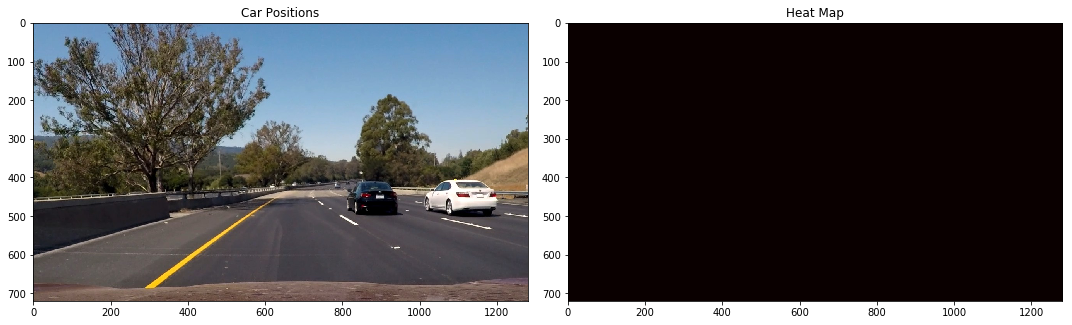

CPU times: user 2.4 s, sys: 2.82 s, total: 5.21 s
Wall time: 1.34 s


In [98]:
%%time
import pickle 

## Load model params
svc=pls[-1]

gl=glob.glob('test_images/*.jpg')
fname=gl[0]
img = mpimg.imread(fname)


ystart = 400
ystop = 720
scale = 1

color_space=color_spaces[-1]
features, bboxes=[[] for i in color_spaces],[]

for scale,ystart,ystop in ((1.5,400,720),):#(1,420,720),(1.5,400,720),(2,400,720)):#,1.5,2):
        fs=[]
        #for i, color in enumerate(color_spaces):
        i, color = len(color_spaces)-1, color_spaces[-1]
        f,b=find_cars(img, ystart, ystop, scale, svc,  color, \
              orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

        features[i].extend(f)
        bboxes.extend(b)
print (len(bboxes))
#pred=[pls[i].predict(features[i]) for i in range(len(color_spaces))]
#pred=np.median(pred,axis=0)
pred=pls[-1].predict(features[-1])

good_boxes=[bboxes[i] for i in range(len(bboxes)) if pred[i]]

heatmap=  get_heat  (img,good_boxes,7)
labels=   get_labels(img, heatmap,7)

fig = plt.figure(figsize=(15,5))


plt.subplot(121)
plt.imshow(labels)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [81]:
h=np.copy(heatmap)

421


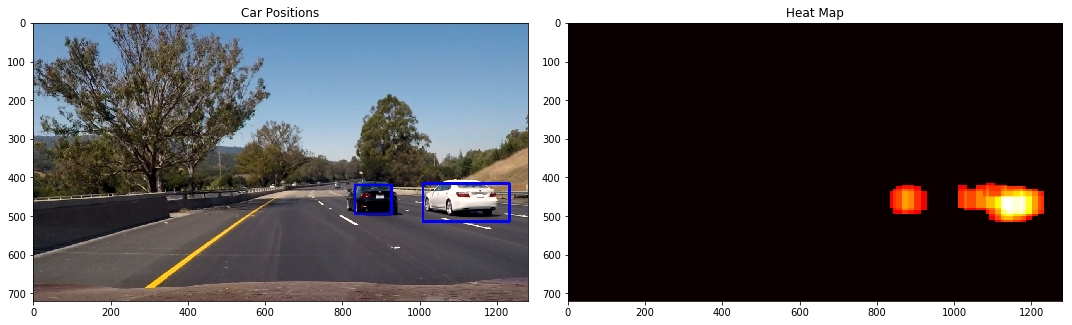

CPU times: user 4.39 s, sys: 3.23 s, total: 7.62 s
Wall time: 2.31 s


In [84]:
%%time

color_space=color_spaces[-1]
features, bboxes=[[] for i in color_spaces],[]

for scale,ystart,ystop in ((1,400,720),(1,420,720),(1.5,400,720),(2,400,720)):#,1.5,2):
        fs=[]
        #for i, color in enumerate(color_spaces):
        i, color = len(color_spaces)-1, color_spaces[-1]
        f,b=find_cars(img, ystart, ystop, scale, svc,  color, \
              orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, heatmap=h)

        features[i].extend(f)
        bboxes.extend(b)

print (len(bboxes))
#pred=[pls[i].predict(features[i]) for i in range(len(color_spaces))]
#pred=np.median(pred,axis=0)
pred=pls[-1].predict(features[-1])

good_boxes=[bboxes[i] for i in range(len(bboxes)) if pred[i]]

heatmap=  get_heat  (img,good_boxes,7)
labels=   get_labels(img, heatmap,7)

fig = plt.figure(figsize=(15,5))


plt.subplot(121)
plt.imshow(labels)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

38


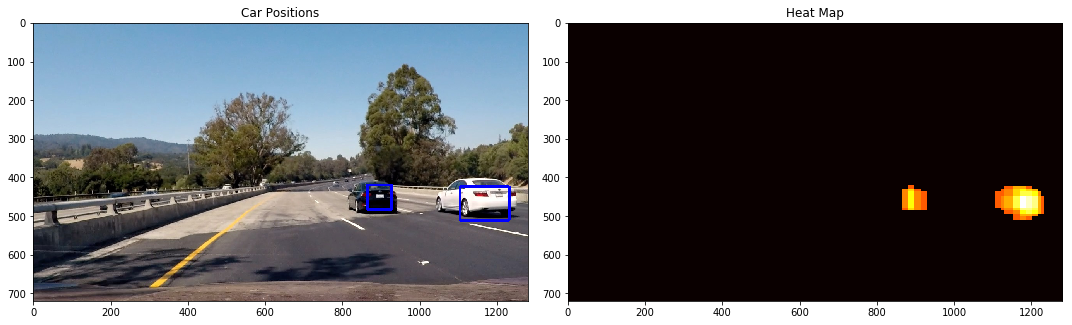

CPU times: user 3.54 s, sys: 664 ms, total: 4.2 s
Wall time: 2.2 s


In [92]:
%%time

color_space=color_spaces[-1]
features, bboxes=[[] for i in color_spaces],[]

for scale,ystart,ystop in ((1,400,720),(1,420,720),(1.5,400,720),(2,400,720)):#,1.5,2):
        fs=[]
        #for i, color in enumerate(color_spaces):
        i, color = len(color_spaces)-1, color_spaces[-1]
        b=find_cars(img, ystart, ystop, scale, svc,  color, \
              orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, heatmap=h, clf=pls[-1])

        #features[i].extend(f)
        bboxes.extend(b)

print (len(bboxes))
#pred=[pls[i].predict(features[i]) for i in range(len(color_spaces))]
#pred=np.median(pred,axis=0)
#pred=pls[-1].predict(features[-1])

good_boxes=bboxes#[bboxes[i] for i in range(len(bboxes)) if pred[i]]

heatmap=  get_heat  (img,good_boxes,7)
labels=   get_labels(img, heatmap,7)

fig = plt.figure(figsize=(15,5))


plt.subplot(121)
plt.imshow(labels)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()